In [1]:
%%time
import datetime as dt
import sys
import os

import scipy as sp
import numpy as np
import pandas as pd

####################
import geopandas
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.ops as shp_ops
import shapely.wkt as wkt
import descartes
import contextily as ctx
#######################

from IPython.display import display, HTML

import fastparquet

import matplotlib.pyplot as plt
%matplotlib inline

Wall time: 16.5 s


In [3]:
%%time
year0 = ['2016-06', '2016-05', '2016-04', '2016-03', '2016-02', '2016-01', '2015-12', '2015-11', '2015-10',
         '2015-09', '2015-08', '2015-07']

col_grn_ext = ['v_id', 'flag', 'extra', 'mta_tax', 'tip', 'tolls', 'ehail_fee', 'improvement_surcharge']
col_ylw_ext = ['v_id', 'flag', 'extra', 'mta_tax', 'tip', 'tolls', 'improvement_surcharge']



col_grn2 = ['v_id', 'pickup_datetime', 'dropoff_datetime', 'flag', 'rate_code', 'pickup_lng',
            'pickup_lat', 'dropoff_lng', 'dropoff_lat', 'psgr_count', 'distance', 'fare', 'extra',
            'mta_tax', 'tip', 'tolls', 'ehail_fee', 'improvement_surcharge', 'total', 'pay_type',
            'trip_type']

col_grn_cat = ['v_id', 'flag', 'rate_code', 'pay_type', 'trip_type']
col_grn_int8 = ['psgr_count']
col_grn_flt16 = ['distance', 'fare', 'extra', 'mta_tax', 'tip', 'tolls', 'ehail_fee',
                  'improvement_surcharge', 'total']
col_green = ['v_id', 'pickup_datetime', 'dropoff_datetime', 'rate_code', 'pickup_lng', 'pickup_lat',
             'dropoff_lng', 'dropoff_lat', 'psgr_count', 'distance', 'fare', 'total', 'pay_type', 'trip_type']


col_green2 = ['pickup_datetime', 'dropoff_datetime', 'rate_code', 'psgr_count', 'distance', 'fare',
              'total', 'pay_type', 'trip_type', 'pickup_lng', 'pickup_lat', 'dropoff_lng', 'dropoff_lat']


col_ylw2 = ['v_id', 'pickup_datetime', 'dropoff_datetime', 'psgr_count', 'distance', 'pickup_lng',
            'pickup_lat', 'rate_code', 'flag', 'dropoff_lng', 'dropoff_lat', 'pay_type', 'fare',
            'extra', 'mta_tax', 'tip', 'tolls', 'improvement_surcharge', 'total']

col_ylw_cat = ['v_id', 'rate_code', 'flag', 'pay_type', 'trip_type']
col_ylw_int8 = ['psgr_count']
col_ylw_flt16 = ['distance', 'fare', 'extra', 'mta_tax', 'tip', 'tolls', 'improvement_surcharge', 'total']
col_yellow = ['v_id', 'pickup_datetime', 'dropoff_datetime', 'psgr_count', 'distance', 'pickup_lng',
            'pickup_lat', 'rate_code', 'dropoff_lng', 'dropoff_lat', 'pay_type', 'fare', 'total']

col_dt = ['pickup_datetime', 'dropoff_datetime']


Wall time: 0 ns


In [4]:
%%time

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))


Wall time: 0 ns


In [6]:
%%time

gdf_to_manhattan_lst = []
gdf_from_manhattan_lst = []
gdf_inside_astoria_lst = []
gdf0_to_manhattan_lst = []
gdf0_from_manhattan_lst = []
gdf0_inside_astoria_lst = []



def file_read_orig(year_month):
    file_grn = 'green_tripdata_' + year_month
    file_ylw = 'yellow_tripdata_' + year_month
    filepath = 'nyc_gov_data'
    fileaddr_grn = os.path.join(filepath,file_grn+'.csv')
    fileaddr_ylw = os.path.join(filepath,file_ylw+'.csv')

    print('-'*30)
    print(year_month)

    print('Reading green trip data ...')
    df_grn = pd.read_csv(fileaddr_grn)
    print('Reading yellow trip data ...')
    df_ylw = pd.read_csv(fileaddr_ylw)

    df_grn.columns = df_grn.columns.str.strip()
    df_ylw.columns = df_ylw.columns.str.strip()

    df_grn.columns = df_grn.columns.str.lower()
    df_ylw.columns = df_ylw.columns.str.lower()

    df_grn.columns = col_grn2
    df_ylw.columns = col_ylw2

    df_ylw['trip_type'] = 'ylw'

    df_grn.loc[:,'psgr_count'] = df_grn.loc[:,'psgr_count'].astype(np.int8)
    df_ylw.loc[:,'psgr_count'] = df_ylw.loc[:,'psgr_count'].astype(np.int8)

    for c in col_dt:
        df_grn.loc[:,c] = pd.to_datetime(df_grn.loc[:,c],format='%Y-%m-%d %H:%M:%S')
        df_ylw.loc[:,c] = pd.to_datetime(df_grn.loc[:,c],format='%Y-%m-%d %H:%M:%S')

    for c in col_grn_cat:
        df_grn.loc[:,c] = df_grn.loc[:,c].astype('category')
    for c in col_ylw_cat:
        df_ylw.loc[:,c] = df_ylw.loc[:,c].astype('category')
    for c in col_grn_flt16:
        df_grn.loc[:,c] = df_grn.loc[:,c].astype(np.float16)
    for c in col_ylw_flt16:
        df_ylw.loc[:,c] = df_ylw.loc[:,c].astype(np.float16)

    df00 = pd.concat([df_ylw[col_green2], df_grn[col_green2]], ignore_index=True)
    df00.loc[:,'loc_type'] = 'neither from or to Astoria'
    df00['trip_type'] = df00['trip_type'].astype(str).astype('category')
    df00.loc[:, 'to_manhattan_box'] = False
    df00.loc[:, 'from_manhattan_box'] = False
    df00.loc[:, 'to_manhattan'] = False
    df00.loc[:, 'from_manhattan'] = False
    df00.loc[:, 'to_astoria'] = False
    df00.loc[:, 'from_astoria'] = False

    df00['pickup_coor'] = list(zip(df00['pickup_lng'], df00['pickup_lat']))
    df00['pickup_coor'] = df00['pickup_coor'].apply(Point)
    df00['dropoff_coor'] = list(zip(df00['dropoff_lng'], df00['dropoff_lat']))
    df00['dropoff_coor'] = df00['dropoff_coor'].apply(Point)
    
    return df00

def data_selection(year_month):
    df00 = file_read_orig(year_month)
    
    gdf0 = geopandas.GeoDataFrame(df00, geometry='pickup_coor')
    gdf = geopandas.GeoDataFrame(gdf0, geometry='dropoff_coor')
    
    gdf0.loc[:, 'from_astoria'] = gdf0.within(astoria_box)
    gdf.loc[:, 'from_astoria'] = gdf0.loc[:, 'from_astoria']
    gdf.loc[:, 'to_astoria'] = gdf.within(astoria_box)
    gdf0.loc[:, 'to_astoria'] = gdf.loc[:, 'to_astoria']
    print('test1')
    gdf.loc[:, 'to_manhattan_box'] = False
    gdf.loc[:, 'to_manhattan'] = False
    gdf.loc[gdf['from_astoria'], 'to_manhattan_box'] = gdf.loc[gdf['from_astoria'], :].within(manhattan_box)
    gdf.loc[gdf['to_manhattan_box'], 'to_manhattan'] = gdf.loc[gdf['to_manhattan_box'], :].within(manhattan)
    gdf0.loc[:, 'to_manhattan'] = gdf.loc[:, 'to_manhattan']
    print('test2')
    gdf0.loc[:, 'from_manhattan_box'] = False
    gdf0.loc[:, 'from_manhattan'] = False
    gdf0.loc[gdf0['to_astoria'], 'from_manhattan_box'] = gdf0.loc[gdf0['to_astoria'], :].within(manhattan_box)
    gdf0.loc[gdf0['from_manhattan_box'], 'from_manhattan'] = gdf0.loc[gdf0['from_manhattan_box'], :].within(manhattan)
    gdf.loc[:, 'from_manhattan'] = gdf0.loc[:, 'from_manhattan']

    print('test3')
    col_to_from = ['to_astoria', 'from_astoria', 'to_manhattan', 'from_manhattan', 'to_manhattan_box',
                   'from_manhattan_box']


    display('final')
    gdf_to_manhattan = gdf.loc[gdf['to_manhattan'], :].drop(columns=col_to_from)
    gdf_from_manhattan = gdf.loc[gdf['from_manhattan'], :].drop(columns=col_to_from)
    gdf_inside_astoria = gdf.loc[gdf['from_astoria'] & gdf['to_astoria'], :].drop(columns=col_to_from)
    gdf0_to_manhattan = gdf0.loc[gdf0['to_manhattan'], :].drop(columns=col_to_from)
    gdf0_from_manhattan = gdf0.loc[gdf0['from_manhattan'], :].drop(columns=col_to_from)
    gdf0_inside_astoria = gdf0.loc[gdf0['from_astoria'] & gdf0['to_astoria'], :].drop(columns=col_to_from)

    
    gdf_to_manhattan_lst.append(gdf_to_manhattan)
    gdf_from_manhattan_lst.append(gdf_from_manhattan)
    gdf_inside_astoria_lst.append(gdf_inside_astoria)
    gdf0_to_manhattan_lst.append(gdf0_to_manhattan)
    gdf0_from_manhattan_lst.append(gdf0_from_manhattan)
    gdf0_inside_astoria_lst.append(gdf0_inside_astoria)


    df00.loc[gdf['to_astoria'] & gdf0['from_astoria'], 'loc_type'] = 'within Astoria'
    df00.loc[gdf['to_manhattan'], 'loc_type'] = ' from Astoria to Manhattan'
    df00.loc[gdf['from_manhattan'], 'loc_type'] = 'from Manhattan to Astoria'
    df00['loc_type'] = df00['loc_type'].astype('category')

    df_selected_cols = ['pickup_datetime', 'dropoff_datetime', 'rate_code', 'psgr_count', 'distance', 'fare',
                        'total', 'pay_type', 'trip_type', 'pickup_lng', 'pickup_lat', 'dropoff_lng', 'dropoff_lat',
                        'loc_type']
    df_selected = df00.loc[df00['loc_type'] != 'neither from or to Astoria', df_selected_cols]

    display(df_selected.shape)
    fname = 'trip_involving_astoria'
    print('Starting the saving')
    fastparquet.write(fname+year_month+'.parq', df_selected, compression='GZIP')
    print(fname+year_month+' done.')



Wall time: 0 ns


In [11]:
%%time

plot_params = dict()
plot_params['figure_SIZE_ratio'] = 2./3.
plot_params['figure_SIZE_x'] = 9
#plot_params[figure_SIZE_y] = figure_SIZE_x*(max_y-min_y)/(max_x-min_x)
#plot_params['figure_SIZE'] = (figure_SIZE_x, figure_SIZE_y)
plot_params['pt_size'] = 1
plot_params['colors'] = {'patch': 'b', 'pont': 'r'}
plot_params['alpha'] = .3
#plot_params['marker'] = []
plot_params['alpha'] = .3
plot_params['dpi'] = 100
plot_params['save_to_png'] = True
plot_params['fig_name'] = 'total'

plt_titles = ['Only trips started from Manhattan and ended in Astoria', 
              'Only trips that started from Astoria and ended in Manhattan',
              'Only trips that started and ended inside Astoria',
              'All points used for this analysis']


#geo_df = [df_select_pickup, df_select_dropoff]
geom_col = ['pickup_coor', 'dropoff_coor']
conditions_col = 'loc_type'
conditions = ['within Astoria', ' from Astoria to Manhattan', 'from Manhattan to Astoria']



def plotting(area_objects, geo_df, geom_col, conditions_col, conditions, plt_titles, **plot_params):
    
    num_figs = len(geom_col)
    union_area = shp_ops.unary_union(area_abjects)
    min_x, min_y, max_x, max_y = mnh_and_ast.bounds
    max_length = max(max_x-min_x, max_y-min_y)
    extended_width = .05 * max_length
    min_x, max_x = min_x-extended_width, max_x+extended_width
    min_y, max_y = min_y-extended_width, max_y+extended_width
    #print(min_x, max_x, min_y, max_y)



    try:
      figure_SIZE_x
    except NameError:
      figure_SIZE_x = fig_SIZE_y*(max_x-min_x)/(max_y-min_y)

    try:
      figure_SIZE_y
    except NameError:
      figure_SIZE_y = fig_SIZE_x*(max_y-min_y)/(max_x-min_x)

    try:
      dpi
    except NameError:
      dpi = 100
    
    figure_SIZE = (figure_SIZE_x, figure_SIZE_y)

    fig = [0] * (num_figs+1)
    ax = [0] * (num_figs+1)
    patch = [0] * (len(area_objects))
    for i in range(num_figs):
        
        fig[i] = plt.figure(i, figsize=figure_SIZE, dpi=dpi)
        ax[i] = fig[i].add_subplot(111)

        for p in range(len(patch)):
            patch[p] = descartes.PolygonPatch(area_objects[p], fc=col['patch'], ec=col['patch'], alpha=alpha, zorder=2)
            ax[i].add_patch(patch)

        for d in range(geo_df):
            s =geo_df[d]
            col = geom_col[d]
            cond = (s[conditions_col] == conditions[i])
            ax[i].scatter(s.loc[cond, col].x, s.loc[cond, col].y, s=pt_size, c=colors['point'], alpha=alpha)

        ax[i].set_xlim(min_x, max_x)
        ax[i].set_xticks([.05*int(i) for i in np.arange(20*min_x, 20*max_x)])
        ax[i].set_ylim(min_y, max_y)
        ax[i].set_yticks([.05*int(i) for i in np.arange(20*min_y, 1+20*max_y)])
        ax[i].set_title(plt_titles[i])
        #ax[i].set_aspect(1)
        
        if save_to_png:
            fig_name += '_' + conditions[i].replace(' ', '_')
            plt.savefig(fig_name+'.png', transparent=True)


    fig[-1] = plt.figure(num_figs, figsize=figure_SIZE, dpi=dpi)
    ax[-1] = fig[-1].add_subplot(111)

    for p in range(len(patch)):
        patch[p] = descartes.PolygonPatch(area_objects[p], fc=col['patch'], ec=col['patch'], alpha=alpha, zorder=2)
        ax[-1].add_patch(patch)

    for d in range(geo_df):
        s =geo_df[d]
        col = geom_col[d]
        for condition in conditions:
            cond = (s[conditions_col] == condition)
            ax[-1].scatter(s.loc[cond, col].x, s.loc[cond, col].y, s=pt_size, c=colors['point'], alpha=alpha)

    ax[-1].set_xlim(min_x, max_x)
    ax[-1].set_xticks([.05*int(i) for i in np.arange(20*min_x, 20*max_x)])
    ax[-1].set_ylim(min_y, max_y)
    ax[-1].set_yticks([.05*int(i) for i in np.arange(20*min_y, 1+20*max_y)])
    ax[-1].set_title(plt_titles[i])
    #ax[i].set_aspect(1)
    if save_to_png:
        fig_name += '_all_types'
        plt.savefig(fig_name+'.png', transparent=True)

    

Wall time: 999 µs


In [7]:
%%time
astoria_pts = []
astoria_pts.append((-73.920156, 40.78269))
astoria_pts.append((-73.905436, 40.772941))
astoria_pts.append((-73.910543, 40.769106))
astoria_pts.append((-73.901746, 40.767416))
astoria_pts.append((-73.913376, 40.753145))
astoria_pts.append((-73.922002, 40.75256))
astoria_pts.append((-73.938824, 40.760265))
astoria_pts.append((-73.945047, 40.76254))
astoria_pts.append((-73.941356, 40.766928))
astoria_pts.append((-73.937365, 40.769138))
astoria_pts.append((-73.935091, 40.771446))
astoria_pts.append((-73.938138, 40.772421))
astoria_pts.append((-73.939254, 40.773038))
astoria_pts.append((-73.938009, 40.776418))
astoria_pts.append((-73.934833, 40.778498))
astoria_pts.append((-73.926679, 40.778498))
astoria_pts.append((-73.920628, 40.78295))

astoria = Polygon(astoria_pts)
astoria_box = astoria.convex_hull

nybb = pd.read_csv('nybb.csv')
nybb_manhattan = nybb.loc[0, :]
manhattan = wkt.loads(nybb_manhattan.the_geom)
manhattan_box = manhattan.convex_hull

for year_month in year0:
    data_selection(year_month)


------------------------------
2016-06
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(133777, 14)

Starting the saving
trip_involving_astoria2016-06 done.
------------------------------
2016-05
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(146166, 14)

Starting the saving
trip_involving_astoria2016-05 done.
------------------------------
2016-04
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(148625, 14)

Starting the saving
trip_involving_astoria2016-04 done.
------------------------------
2016-03
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(155548, 14)

Starting the saving
trip_involving_astoria2016-03 done.
------------------------------
2016-02
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(143975, 14)

Starting the saving
trip_involving_astoria2016-02 done.
------------------------------
2016-01
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(146741, 14)

Starting the saving
trip_involving_astoria2016-01 done.
------------------------------
2015-12
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(150409, 14)

Starting the saving
trip_involving_astoria2015-12 done.
------------------------------
2015-11
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(141187, 14)

Starting the saving
trip_involving_astoria2015-11 done.
------------------------------
2015-10
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(149517, 14)

Starting the saving
trip_involving_astoria2015-10 done.
------------------------------
2015-09
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(137766, 14)

Starting the saving
trip_involving_astoria2015-09 done.
------------------------------
2015-08
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(145735, 14)

Starting the saving
trip_involving_astoria2015-08 done.
------------------------------
2015-07
Reading green trip data ...
Reading yellow trip data ...
test1
test2
test3


'final'

(152015, 14)

Starting the saving
trip_involving_astoria2015-07 done.
------------------------------
2015-06
Reading green trip data ...
Reading yellow trip data ...


D:\ProgramData\Anaconda3\envs\nyc_20181222\lib\site-packages\IPython\core\interactiveshell.py:2323: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = fn(magic_arg_s, cell)


ValueError: time data N doesn't match format specified

In [13]:
%%time

geom_col = ['pickup_coor', 'dropoff_coor']
conditions_col = 'loc_type'
conditions = ['within Astoria', ' from Astoria to Manhattan', 'from Manhattan to Astoria']

#geo_df = [df_select_pickup, df_select_dropoff]


#plotting(area_objects, geo_df, geom_col, conditions_col, conditions, plt_titles, **plot_params)

gdf_to_manhattan_tot = pd.concat(gdf_to_manhattan_lst)
gdf_from_manhattan_tot = pd.concat(gdf_from_manhattan_lst)
gdf_inside_astoria_tot = pd.concat(gdf_inside_astoria_lst)
gdf0_to_manhattan_tot = pd.concat(gdf0_to_manhattan_lst)
gdf0_from_manhattan_tot = pd.concat(gdf0_from_manhattan_lst)
gdf0_inside_astoria_tot = pd.concat(gdf0_inside_astoria_lst)

display(gdf_to_manhattan_tot.shape)
display(gdf_from_manhattan_tot.shape)
display(gdf_inside_astoria_tot.shape)
display(gdf0_to_manhattan_tot.shape)
display(gdf0_from_manhattan_tot.shape)
display(gdf0_inside_astoria_tot.shape)


(267063, 16)

(765320, 16)

(719121, 16)

(267063, 16)

(765320, 16)

(719121, 16)

Wall time: 2.47 s


In [18]:
%%time
fname = 'trip_involving_astoria'
sel_cols = ['pickup_datetime', 'dropoff_datetime', 'rate_code', 'psgr_count', 'distance', 'fare', 'total',
            'pay_type', 'trip_type', 'pickup_lng', 'pickup_lat', 'dropoff_lng', 'dropoff_lat', 'loc_type']




print('Starting the saving')
fastparquet.write(fname+'_to_manhattan_tot'+'.parq', gdf_to_manhattan_tot.loc[:,sel_cols], compression='GZIP')
print(fname+'_2016-15'+' done.')

fastparquet.write(fname+'_from_manhattan_tot'+'.parq', gdf_from_manhattan_tot.loc[:,sel_cols], compression='GZIP')
print(fname+'_2016-15'+' done.')

fastparquet.write(fname+'_inside_astoria_tot'+'.parq', gdf_inside_astoria_tot.loc[:,sel_cols], compression='GZIP')
print(fname+'_2016-15'+' done.')

fastparquet.write(fname+'_to_manhattan0_tot'+'.parq', gdf0_to_manhattan_tot.loc[:,sel_cols], compression='GZIP')
print(fname+'_2016-15'+' done.')

fastparquet.write(fname+'_from_manhattan0_tot'+'.parq', gdf0_from_manhattan_tot.loc[:,sel_cols], compression='GZIP')
print(fname+'_2016-15'+' done.')

fastparquet.write(fname+'_inside_astoria0_tot'+'.parq', gdf0_inside_astoria_tot.loc[:,sel_cols], compression='GZIP')
print(fname+'_2016-15'+' done.')


Starting the saving
trip_involving_astoria_2016-15 done.
trip_involving_astoria_2016-15 done.
trip_involving_astoria_2016-15 done.
trip_involving_astoria_2016-15 done.
trip_involving_astoria_2016-15 done.
trip_involving_astoria_2016-15 done.
Wall time: 25.8 s


-74.05753568206349 -73.8919399449069 40.673110890352014 40.88884410240033
Wall time: 2min 58s


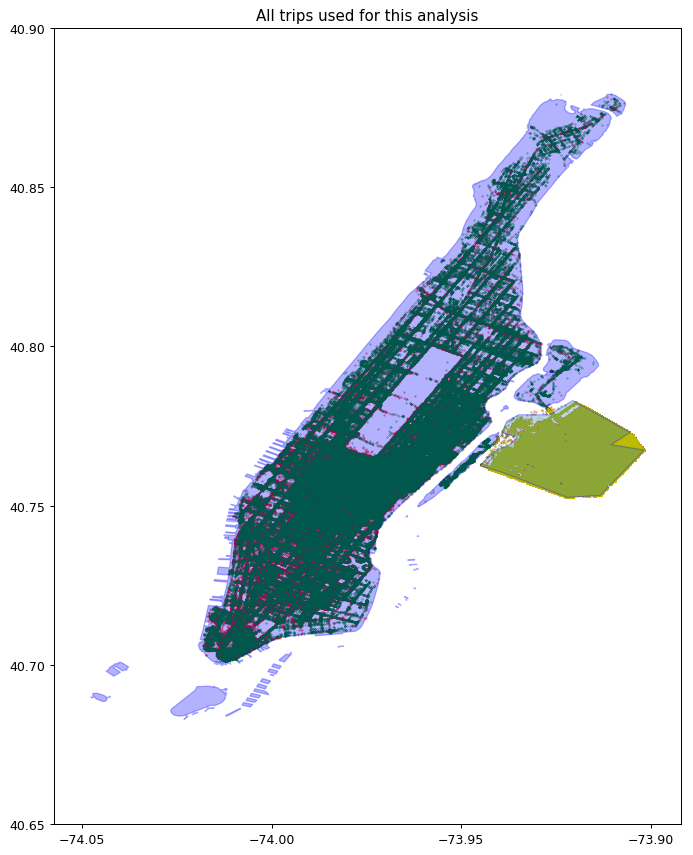

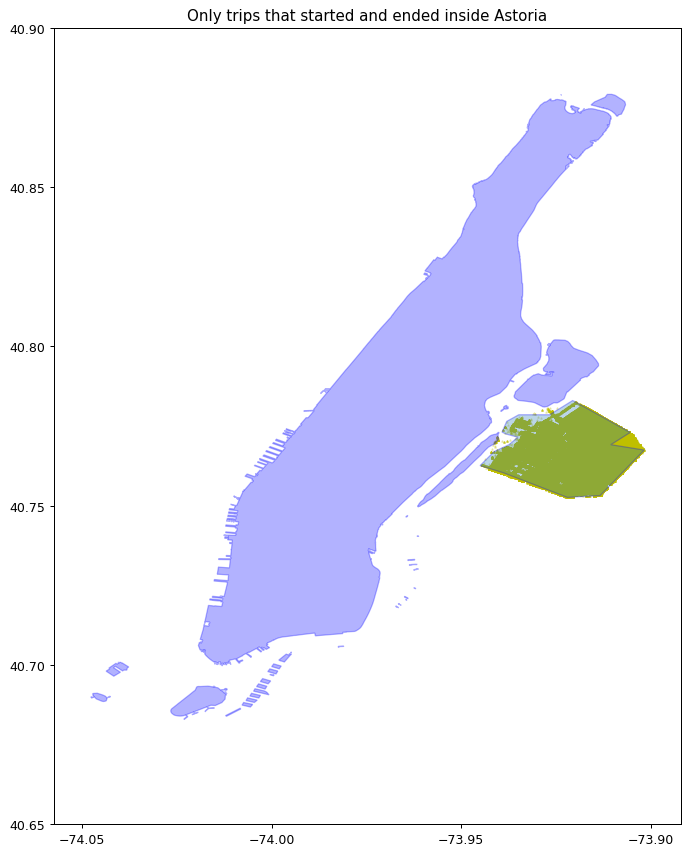

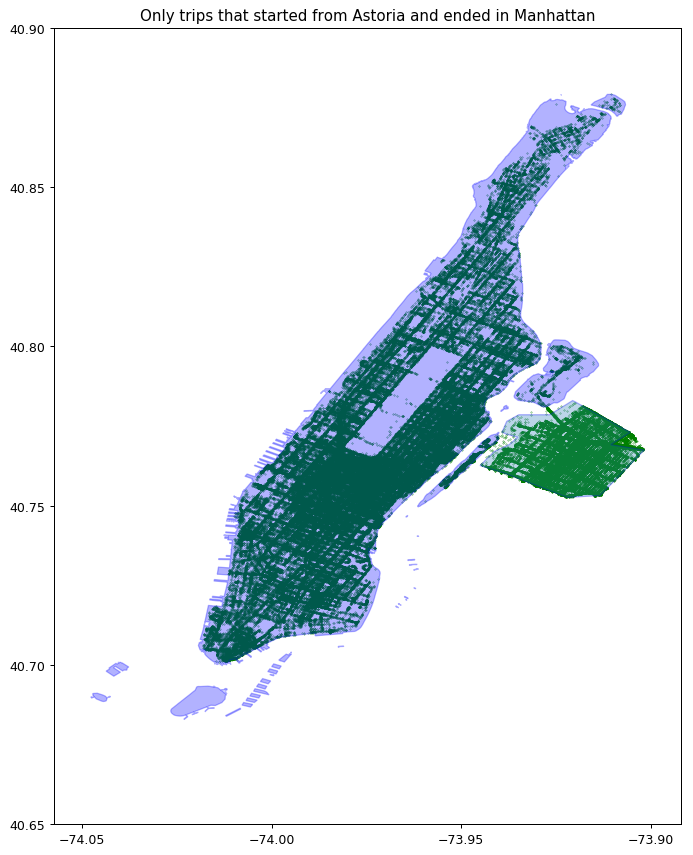

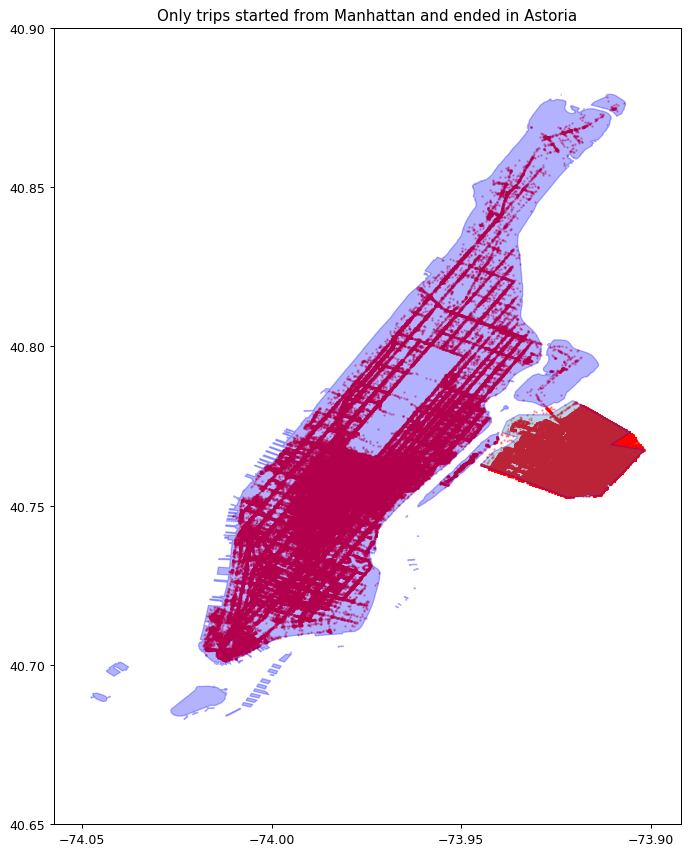

In [19]:
%%time
mnh_and_ast = shp_ops.unary_union([manhattan, astoria])
min_x, min_y, max_x, max_y = mnh_and_ast.bounds
max_length = max(max_x-min_x, max_y-min_y)
extended_width = .05*max_length
min_x, max_x = min_x-extended_width, max_x+extended_width
min_y, max_y = min_y-extended_width, max_y+extended_width
print(min_x, max_x, min_y, max_y)


# plot data separately
figure_SIZE_ratio = 2./3.
figure_SIZE_x = 9
figure_SIZE_y = figure_SIZE_x*(max_y-min_y)/(max_x-min_x)
figure_SIZE = (figure_SIZE_x, figure_SIZE_y)
col0 = 'b'


fig1 = plt.figure(1, figsize=figure_SIZE, dpi=90)
ax1 = fig1.add_subplot(111)

mnh_patch = descartes.PolygonPatch(manhattan, fc=col0, ec=col0, alpha=0.3, zorder=2)
ast_patch = descartes.PolygonPatch(astoria, ec=col0, alpha=0.3, zorder=2)

ax1.add_patch(mnh_patch)
ax1.add_patch(ast_patch)
ax1.scatter(gdf0_from_manhattan_tot.pickup_coor.x, gdf0_from_manhattan_tot.pickup_coor.y, s=1, c='r', 
            marker='o', alpha=0.3)
ax1.scatter(gdf_from_manhattan_tot.dropoff_coor.x, gdf_from_manhattan_tot.dropoff_coor.y, s=1, c='r', 
            marker='o', alpha=0.3)
ax1.scatter(gdf0_to_manhattan_tot.pickup_coor.x, gdf0_to_manhattan_tot.pickup_coor.y, s=1, c='g', 
            marker='x', alpha=0.3)
ax1.scatter(gdf_to_manhattan_tot.dropoff_coor.x, gdf_to_manhattan_tot.dropoff_coor.y, s=1, c='g', 
            marker='x', alpha=0.3)
ax1.scatter(gdf0_inside_astoria_tot.pickup_coor.x, gdf0_inside_astoria_tot.pickup_coor.y, s=1, c='y', 
            marker='^', alpha=0.3)
ax1.scatter(gdf_inside_astoria_tot.dropoff_coor.x, gdf_inside_astoria_tot.dropoff_coor.y, s=1, c='y', 
            marker='^', alpha=0.3)

ax1.set_xlim(min_x, max_x)
ax1.set_xticks([.05*int(i) for i in np.arange(20*min_x, 20*max_x)])
ax1.set_ylim(min_y, max_y)
ax1.set_yticks([.05*int(i) for i in np.arange(20*min_y, 1+20*max_y)])
ax1.set_title('All trips used for this analysis')
#ax1.set_aspect(1)


# only insie Astoria
fig2 = plt.figure(2, figsize=figure_SIZE, dpi=90)
ax2 = fig2.add_subplot(111)

mnh_patch = descartes.PolygonPatch(manhattan, fc=col0, ec=col0, alpha=0.3, zorder=2)
ast_patch = descartes.PolygonPatch(astoria, ec=col0, alpha=0.3, zorder=2)

ax2.add_patch(mnh_patch)
ax2.add_patch(ast_patch)
ax2.scatter(gdf0_inside_astoria_tot.pickup_coor.x, gdf0_inside_astoria_tot.pickup_coor.y, s=1, c='y', 
            marker='^', alpha=0.3)
ax2.scatter(gdf_inside_astoria_tot.dropoff_coor.x, gdf_inside_astoria_tot.dropoff_coor.y, s=1, c='y',
            marker='^', alpha=0.3)

ax2.set_xlim(min_x, max_x)
ax2.set_xticks([.05*int(i) for i in np.arange(20*min_x, 20*max_x)])
ax2.set_ylim(min_y, max_y)
ax2.set_yticks([.05*int(i) for i in np.arange(20*min_y, 1+20*max_y)])
ax2.set_title('Only trips that started and ended inside Astoria')
#ax2.set_aspect(1)


# from Astoria to Manhattan
fig3 = plt.figure(3, figsize=figure_SIZE, dpi=90)
ax3 = fig3.add_subplot(111)

mnh_patch = descartes.PolygonPatch(manhattan, fc=col0, ec=col0, alpha=0.3, zorder=2)
ast_patch = descartes.PolygonPatch(astoria, ec=col0, alpha=0.3, zorder=2)

ax3.add_patch(mnh_patch)
ax3.add_patch(ast_patch)
ax3.scatter(gdf0_to_manhattan_tot.pickup_coor.x, gdf0_to_manhattan_tot.pickup_coor.y, s=1, c='g', 
            marker='x', alpha=0.3)
ax3.scatter(gdf_to_manhattan_tot.dropoff_coor.x, gdf_to_manhattan_tot.dropoff_coor.y, s=1, c='g', 
            marker='x', alpha=0.3)

ax3.set_xlim(min_x, max_x)
ax3.set_xticks([.05*int(i) for i in np.arange(20*min_x, 20*max_x)])
ax3.set_ylim(min_y, max_y)
ax3.set_yticks([.05*int(i) for i in np.arange(20*min_y, 1+20*max_y)])
ax3.set_title('Only trips that started from Astoria and ended in Manhattan')
#ax3.set_aspect(1)

# from Manhattan to Astoria
fig4 = plt.figure(4, figsize=figure_SIZE, dpi=90)
ax4 = fig4.add_subplot(111)

mnh_patch = descartes.PolygonPatch(manhattan, fc=col0, ec=col0, alpha=0.3, zorder=2)
ast_patch = descartes.PolygonPatch(astoria, ec=col0, alpha=0.3, zorder=2)

ax4.add_patch(mnh_patch)
ax4.add_patch(ast_patch)
ax4.scatter(gdf0_from_manhattan_tot.pickup_coor.x, gdf0_from_manhattan_tot.pickup_coor.y, s=1, c='r', 
            marker='o', alpha=0.3)
ax4.scatter(gdf_from_manhattan_tot.dropoff_coor.x, gdf_from_manhattan_tot.dropoff_coor.y, s=1, c='r', 
            marker='o', alpha=0.3)

ax4.set_xlim(min_x, max_x)
ax4.set_xticks([.05*int(i) for i in np.arange(20*min_x, 20*max_x)])
ax4.set_ylim(min_y, max_y)
ax4.set_yticks([.05*int(i) for i in np.arange(20*min_y, 1+20*max_y)])
ax4.set_title('Only trips started from Manhattan and ended in Astoria')
#ax4.set_aspect(1)


Wall time: 38.3 s


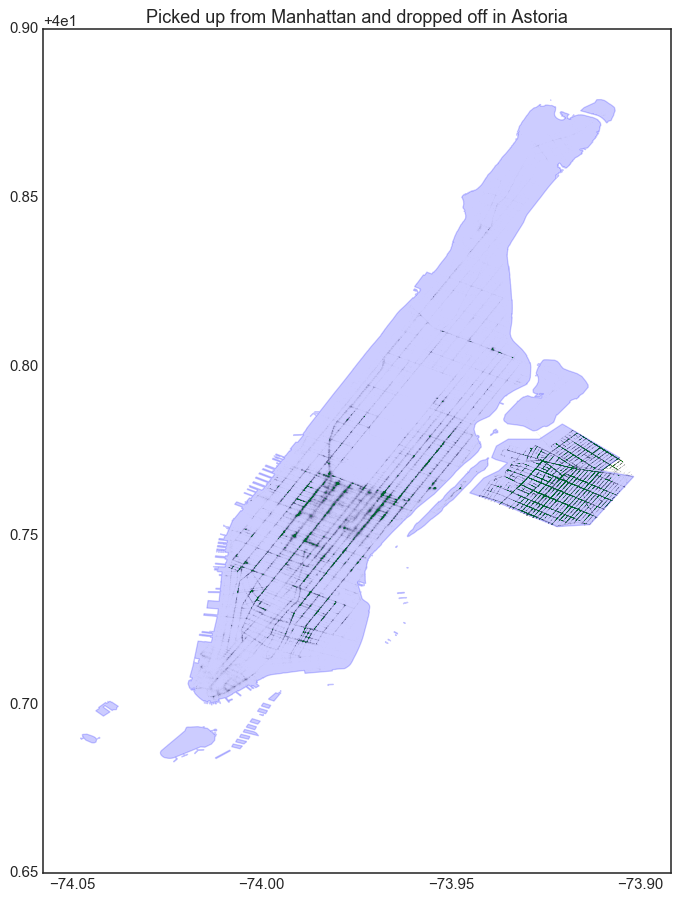

In [53]:
%%time
plt.style.use('seaborn-white')
fig0 = plt.figure(11, figsize=figure_SIZE, dpi=90)
ax0 = fig0.add_subplot(111)

mnh_patch = descartes.PolygonPatch(manhattan, fc=col0, ec=col0, alpha=0.2, zorder=2)
ast_patch = descartes.PolygonPatch(astoria, ec=col0, alpha=0.2, zorder=2)

ax0.add_patch(mnh_patch)
ax0.add_patch(ast_patch)
#counts0, xedges0, yedge0s, im0 = ax0.hist2d(gdf0_from_manhattan_tot.iloc[:,:].pickup_coor.x, 
#                                            gdf0_from_manhattan_tot.iloc[:,:].pickup_coor.y, bins=10000, 
#                                            cmin=10, cmap='Blues', alpha=1)
#counts, xedges, yedges, im = ax0.hist2d(gdf_from_manhattan_tot.iloc[:,:].dropoff_coor.x, 
#                                        gdf_from_manhattan_tot.iloc[:,:].dropoff_coor.y, bins = 50000,
#                                        cmin=10, cmap='Greys', alpha=1)
ax0.scatter(gdf0_from_manhattan_tot.pickup_coor.x, gdf0_from_manhattan_tot.pickup_coor.y, s=.05, c='g', 
            marker='x', alpha=0.005)
ax0.scatter(gdf_from_manhattan_tot.dropoff_coor.x, gdf_from_manhattan_tot.dropoff_coor.y, s=.05, c='g', 
            marker='x', alpha=0.005)
#ax0.scatter(gdf0_to_manhattan_tot.pickup_coor.x, gdf0_to_manhattan_tot.pickup_coor.y, s=1, c='g', 
#            marker='x', alpha=0.3)
#ax0.scatter(gdf_to_manhattan_tot.dropoff_coor.x, gdf_to_manhattan_tot.dropoff_coor.y, s=1, c='g', 
#            marker='x', alpha=0.3)
#ax0.scatter(gdf0_inside_astoria_tot.pickup_coor.x, gdf0_inside_astoria_tot.pickup_coor.y, s=1, c='y', 
#            marker='^', alpha=0.3)
#ax0.scatter(gdf_inside_astoria_tot.dropoff_coor.x, gdf_inside_astoria_tot.dropoff_coor.y, s=1, c='y', 
#            marker='^', alpha=0.3)


ax0.set_xlim(min_x, max_x)
ax0.set_xticks([.05*int(i) for i in np.arange(20*min_x, 20*max_x)])
ax0.set_ylim(min_y, max_y)
ax0.set_yticks([.05*int(i) for i in np.arange(20*min_y, 1+20*max_y)])
ax0.set_title('Picked up from Manhattan and dropped off in Astoria')
#ax0.set_title('All trips used for this analysis')
#ax1.set_aspect(1)

#plt.colorbar(im, ax=ax0, orientation='horizontal', label='drop off location')
#plt.colorbar(im0, ax=ax0, orientation='vertical', label='pick up location')


Text(0.5, 1.0, 'Picked up from Manhattan and dropped off in Astoria')

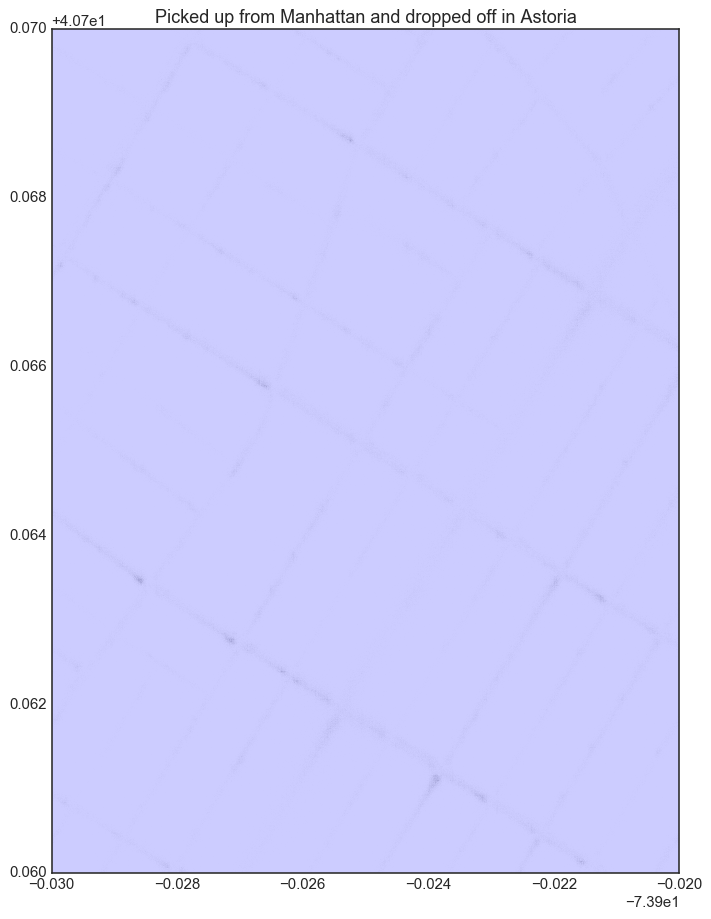

In [55]:
fig0 = plt.figure(11, figsize=figure_SIZE, dpi=90)
ax0 = fig0.add_subplot(111)

mnh_patch = descartes.PolygonPatch(manhattan, fc=col0, ec=col0, alpha=0.2, zorder=2)
ast_patch = descartes.PolygonPatch(astoria, ec=col0, alpha=0.2, zorder=2)

ax0.add_patch(mnh_patch)
ax0.add_patch(ast_patch)
#counts0, xedges0, yedge0s, im0 = ax0.hist2d(gdf0_from_manhattan_tot.iloc[:,:].pickup_coor.x, 
#                                            gdf0_from_manhattan_tot.iloc[:,:].pickup_coor.y, bins=10000, 
#                                            cmin=10, cmap='Blues', alpha=1)
#counts, xedges, yedges, im = ax0.hist2d(gdf_from_manhattan_tot.iloc[:,:].dropoff_coor.x, 
#                                        gdf_from_manhattan_tot.iloc[:,:].dropoff_coor.y, bins = 50000,
#                                        cmin=10, cmap='Greys', alpha=1)
ax0.scatter(gdf0_from_manhattan_tot.pickup_coor.x, gdf0_from_manhattan_tot.pickup_coor.y, s=.05, c='g', 
            marker='x', alpha=0.005)
ax0.scatter(gdf_from_manhattan_tot.dropoff_coor.x, gdf_from_manhattan_tot.dropoff_coor.y, s=.05, c='g', 
            marker='x', alpha=0.005)
#ax0.scatter(gdf0_to_manhattan_tot.pickup_coor.x, gdf0_to_manhattan_tot.pickup_coor.y, s=1, c='g', 
#            marker='x', alpha=0.3)
#ax0.scatter(gdf_to_manhattan_tot.dropoff_coor.x, gdf_to_manhattan_tot.dropoff_coor.y, s=1, c='g', 
#            marker='x', alpha=0.3)
#ax0.scatter(gdf0_inside_astoria_tot.pickup_coor.x, gdf0_inside_astoria_tot.pickup_coor.y, s=1, c='y', 
#            marker='^', alpha=0.3)
#ax0.scatter(gdf_inside_astoria_tot.dropoff_coor.x, gdf_inside_astoria_tot.dropoff_coor.y, s=1, c='y', 
#            marker='^', alpha=0.3)


ax0.set_xlim(-73.93,-73.92)
#ax0.set_xticks([.05*int(i) for i in np.arange(20*min_x, 20*max_x)])
ax0.set_ylim(40.76,40.77)
#ax0.set_yticks([.05*int(i) for i in np.arange(20*min_y, 1+20*max_y)])
ax0.set_title('Picked up from Manhattan and dropped off in Astoria')
#ax0.set_title('All trips used for this analysis')
#ax1.set_aspect(1)

#plt.colorbar(im, ax=ax0, orientation='horizontal', label='drop off location')
#plt.colorbar(im0, ax=ax0, orientation='vertical', label='pick up location')


In [62]:
%%time
nyc_latitude = 40.730610
nyc_longitude = -73.935242

lng_to_mile = 52.34765958223438
lat_to_mile = 69.04799987565435

mile_to_lng = 1./lng_to_mile
mile_to_lat = 1./lat_to_mile

display(mile_to_lng/10)
display(mile_to_lat/10)

0.001910305079502308

0.0014482678742336608

Wall time: 2.98 ms
